In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt

sns.set_theme()

In [262]:
mean_tmp = pd.read_csv( 'mean-monthly-air-temperature-deg.csv')
air_df = pd.read_csv('international-airline-passengers.csv')

* Посчитаем тест Дики-Фулера для выбранных рядов

In [263]:
print('mean_tmp adfuller:', adfuller(mean_tmp['Deg'], autolag='AIC')[1])
print('air_df adfuller:', adfuller(air_df['Count'], autolag='AIC')[1])

mean_tmp adfuller: 0.016989030222608826
air_df adfuller: 0.9918802434376409


In [100]:
mean_tmp_train, mean_tmp_test = mean_tmp['Deg'][:-10], mean_tmp['Deg'][-10:]
air_df_train, air_df_test = air_df['Count'][:-10], air_df['Count'][-10:]

* Считаем предсказания для обычного скользящего среднего


In [264]:
def moving_average_pred(data,window,pred_,test):
    new_data = data.copy()
    
    for i in range(pred_):
        pred = pd.Series([new_data[-window:].mean()])
        new_data = new_data.append(pred, ignore_index=True)
        
    moving_average_rsme = mean_squared_error(test,new_data[-10:])

    return new_data, moving_average_rsme


In [103]:
moving_average_predictions = moving_average_pred(mean_tmp_train,7,10,mean_tmp_test)
moving_average_predictions_rsme = moving_average_predictions[1]
moving_average_predictions_rsme

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2509099439.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(pred, ignore_index=True)


117.79996684872063

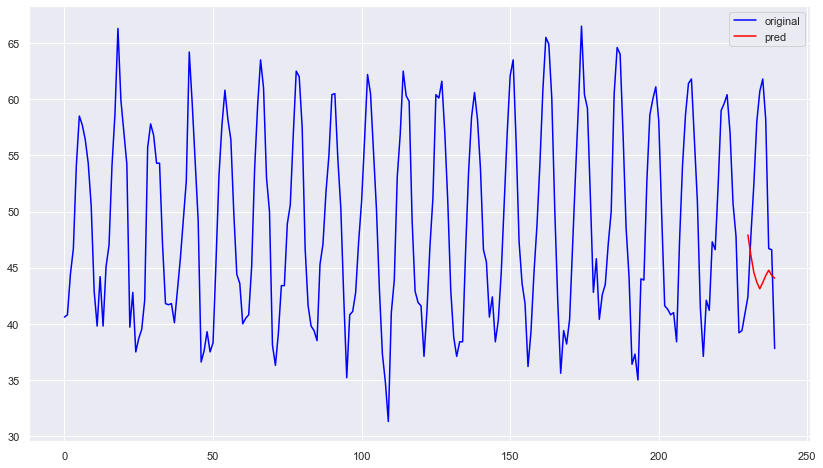

In [98]:
plt.figure(figsize=(14, 8))
plt.plot(mean_tmp['Deg'],color='blue',label='original');
plt.plot(moving_average_predictions[0][-10:],color='red',label='pred');
plt.legend();


In [105]:
moving_average_pred(air_df_train,7,10,air_df_test)[1]

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2509099439.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(pred, ignore_index=True)


12306.562773967755

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2509099439.py:6: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_data = new_data.append(pred, ignore_index=True)


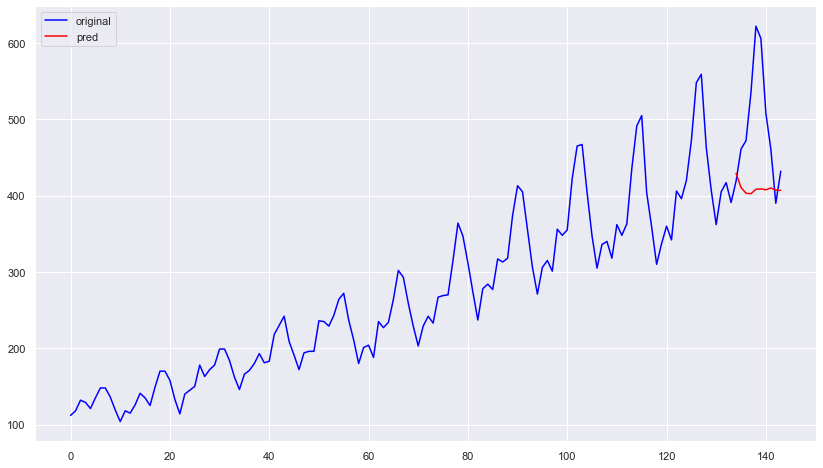

In [106]:
plt.figure(figsize=(14, 8))
plt.plot(air_df['Count'],color='blue',label='original');
plt.plot(moving_average_pred(air_df_train,7,10,air_df_test)[0][-10:],color='red',label='pred');
plt.legend();

* **Итог:** для нестационарного ряда rsme намного больше, чем для стационарного, но судя по всему они совершенно в разных координатах сущетсвуют, тут следовало бы стандартизировать для корректного сравнения
* Теперь реализуем скользящее с весами

In [265]:
### сначала хотел сам написать такую функцию,
### но тут в целом то же самое и получается, так что не буду мудрить

def weighted_moving_average(series, n, weights,p):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    
    for i in range(p):
        
        pred = pd.Series((wma[-n:]* weights).sum() / weights.sum())
        wma = wma.append(pred, ignore_index=True)
    
    return wma

In [133]:
pred_weighted = weighted_moving_average(mean_tmp_train,7,[1,1,2,3,5,8,13],10)
mean_squared_error(mean_tmp_test,pred_weighted[-10:])

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/3283086788.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wma = wma.append(pred, ignore_index=True)


91.93759481077225

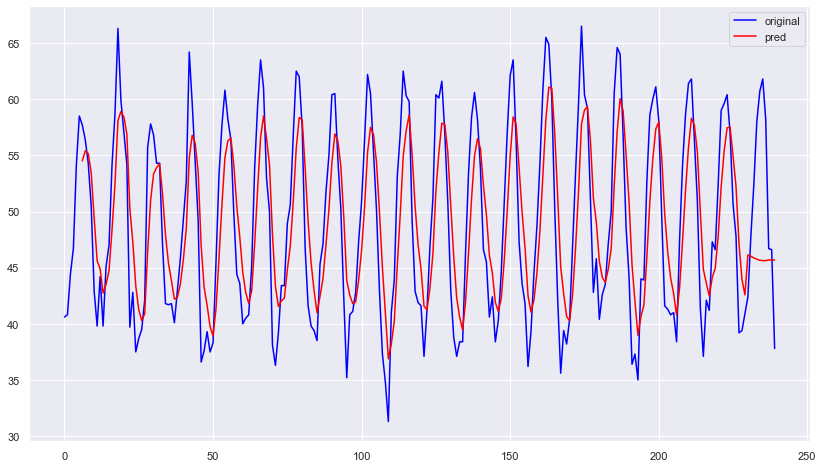

In [135]:
plt.figure(figsize=(14, 8))
plt.plot(mean_tmp['Deg'],color='blue',label='original');
plt.plot(pred_weighted,color='red',label='pred');
plt.legend();

In [281]:
pred_weighted_air = weighted_moving_average(air_df_train,7,[1,1,2,3,5,8,13],10)
mean_squared_error(air_df_test,pred_weighted_air[-10:])

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2519520408.py:14: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wma = wma.append(pred, ignore_index=True)


10719.287918211023

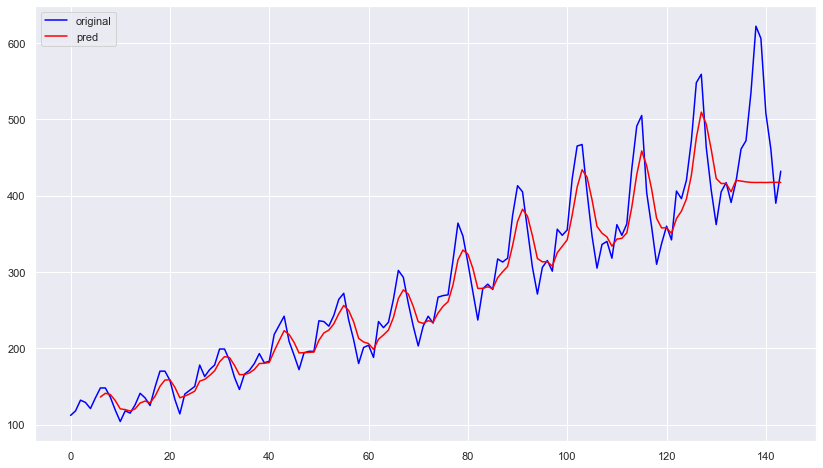

In [138]:
plt.figure(figsize=(14, 8))
plt.plot(air_df['Count'],color='blue',label='original');
plt.plot(pred_weighted_air,color='red',label='pred');
plt.legend();

* **Итог:** Для обоих рядов скользящее с весами показало более хороший результат, исходя из mse
* Теперь перейдем к сглаживанию

In [277]:
def exponential_moving_average(series, alpha, n_pred=None):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n-1] + (1 - alpha) * result[n-1])
        
    if not n_pred:
        return pd.Series(result)
    
    predictions = [alpha * series[len(series) - 1] + (1 - alpha) * result[-1]]

    for _ in range(n_pred):
        
        res = alpha * predictions[-1] + (1 - alpha) * result[-1]
        result.append(res)
        predictions.append(res)
        
        
    return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result),predictions

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2258059890.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result),predictions
C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2258059890.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result),predictions


MSE 65.20939278949338


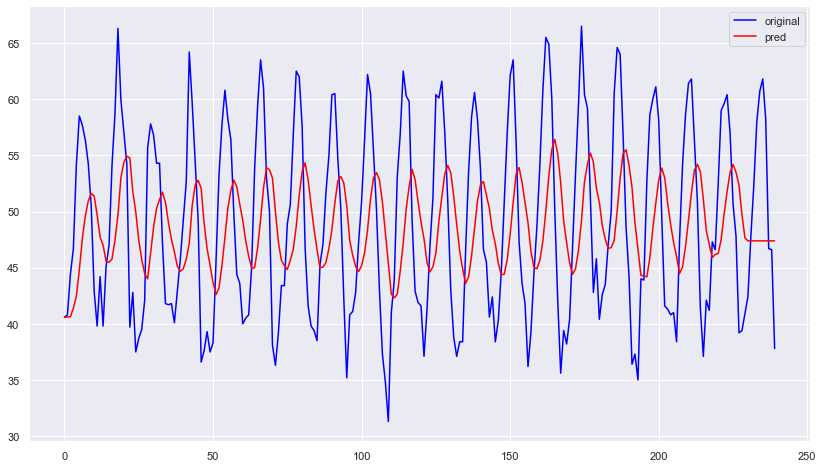

In [328]:
### реализуем для сглаживание для стационарного ряда
print('MSE',mean_squared_error(mean_tmp_test,exponential_moving_average(mean_tmp_train,0.1,9)[2]))
plt.figure(figsize=(14, 8))
plt.plot(mean_tmp['Deg'],color='blue',label='original');
plt.plot(exponential_moving_average(mean_tmp_train,0.2,10)[1],color='red',label='pred');
plt.legend();

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2258059890.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result),predictions
C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2258059890.py:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(predictions), ignore_index=True), pd.Series(result),predictions


MSE: 11026.629970355485


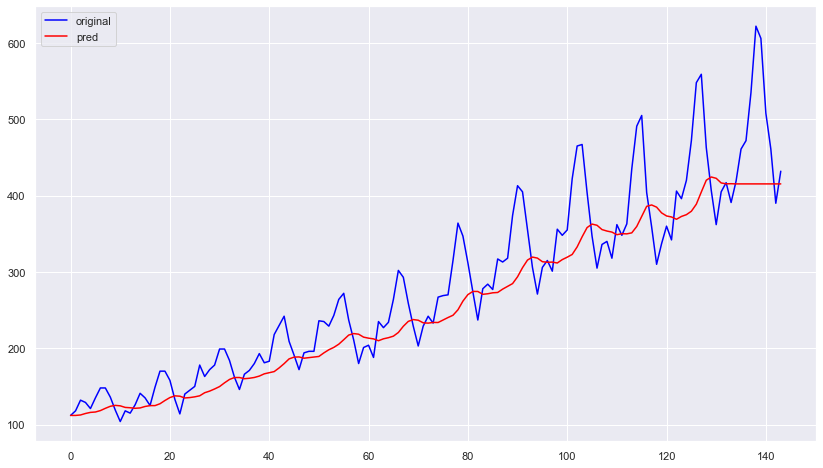

In [295]:
### реализуем для сглаживание для нестационарного ряда
print('MSE:',mean_squared_error(air_df_test,exponential_moving_average(air_df_train,0.1,9)[2]))
plt.figure(figsize=(14, 8))
plt.plot(air_df['Count'],color='blue',label='original');
plt.plot(exponential_moving_average(air_df_train,0.1,10)[1],color='red',label='pred');
plt.legend();

* **Итог:** для стационарного ряда зафиксировано снижение квадрата ошибки, для нестационраного незначительное  увеличение ошибки
* Перейдем к двойному сглаживанию

$$\hat{y}_t=l_t + s_t$$

$$\hat{y}_t=\alpha y_t + (1-\alpha)\hat{y}_{t-1}$$

$$\hat{l}_t = \alpha y_t + (1-\alpha)(l_{t-1} + s_{t-1})$$

$$s_t = \beta (l_t - l_{t-1}) + (1 - \beta) s_{t-1}$$

In [300]:
def double_ema_with_preds(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    
    for n in range(1, len(series)):
        value = series[n]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    preds = []
    for n in range(n_preds):
        value = result[-1]
        
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        
        trend = beta*(level-last_level) + (1-beta)*trend
        
        result.append(level+trend)
        preds.append(level+trend)

    return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds

C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds
C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds


MSE: 92.8133152941687


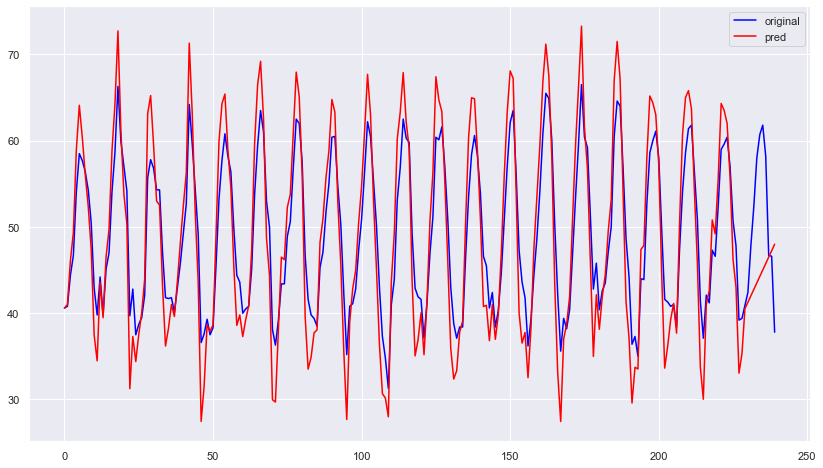

In [309]:
### реализуем для стационарного ряда
print('MSE:',mean_squared_error(mean_tmp_test,double_ema_with_preds(mean_tmp_train,0.99,0.99,10)[2]))
plt.figure(figsize=(14, 8))
plt.plot(mean_tmp['Deg'],color='blue',label='original');
plt.plot(double_ema_with_preds(mean_tmp_train,0.8,0.8,10)[1],color='red',label='pred');
plt.legend();


C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds
C:\Users\683A~1\AppData\Local\Temp/ipykernel_22068/2090657853.py:24: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return series.append(pd.Series(preds), ignore_index=True), pd.Series(result),preds


MSE: 6578.955706514431


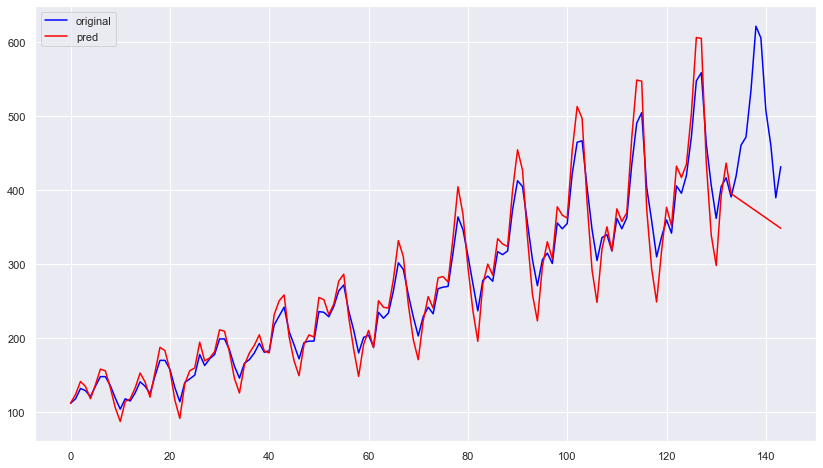

In [315]:
### реализуем для нестационарного ряда
print('MSE:',mean_squared_error(air_df_test,double_ema_with_preds(air_df_train,0.1,0.2,10)[2]))
plt.figure(figsize=(14, 8))
plt.plot(air_df['Count'],color='blue',label='original');
plt.plot(double_ema_with_preds(air_df_train,0.8,0.8,10)[1],color='red',label='pred');
plt.legend();

* **Итог:** для стационраного ряда были показаны не самые лучшие, но и не худшие результаты, а вот для нестационарного получены самые лучшие, посмотрим, что будет на тройном сглаживании

In [316]:
def initial_trend(series, season_len):
    sum = 0.0
    for i in range(season_len):
        sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len


def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals


def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser, ser_to_plot, n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    
    with plt.style.context('bmh'):
        
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.axvline (x=len(ser.index),ymax=1, color='brown', linestyle='--',label='sep between train and original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

MSE: 29.082908656144905


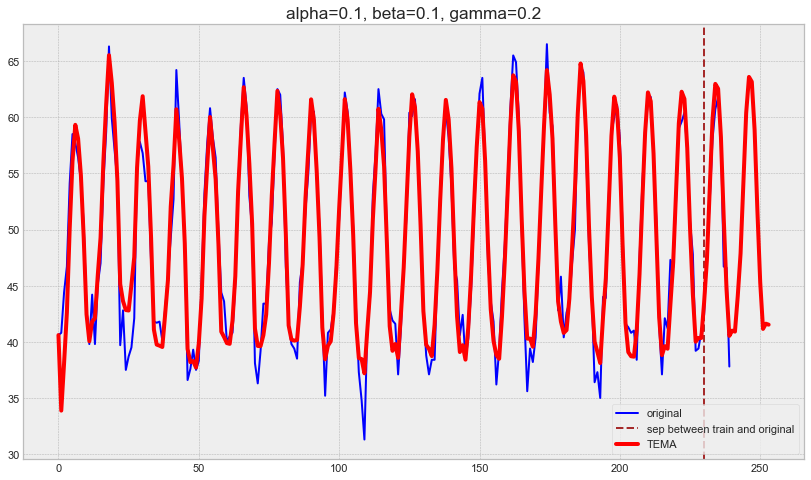

In [326]:
print('MSE:',mean_squared_error(mean_tmp_test,triple_exponential_smoothing(mean_tmp_train, 12, 0.1, 0.1, 0.2, 9)[-10:]))

plot_tema(0.1, 0.1, 0.2,mean_tmp_train,mean_tmp['Deg'])

MSE: 3129.5881382325697


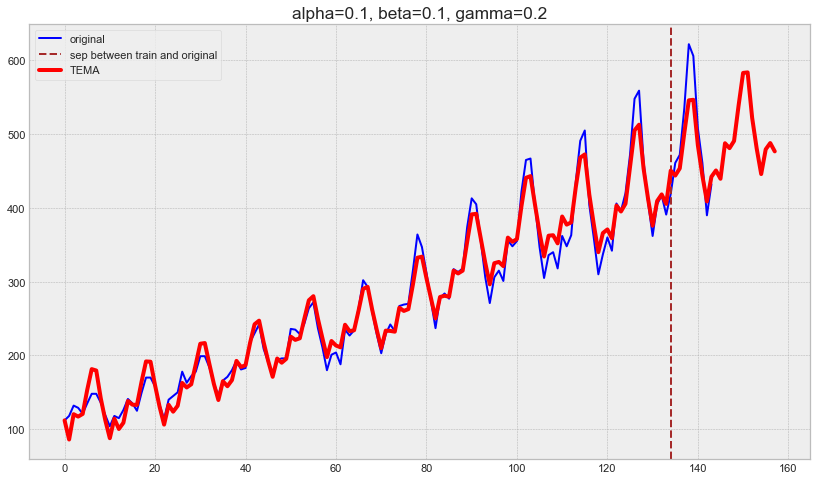

In [327]:
print('MSE:',mean_squared_error(air_df_test,triple_exponential_smoothing(air_df_train, 12, 0.1, 0.1, 0.2, 9)[-10:]))

plot_tema(0.1, 0.1, 0.2,air_df_train,air_df['Count'])

## Итог:
* Тройное сглаживание показало для обоих рядов самые лучшие метрики по MSE, что собственно и логично, исходя из сложности самого метода
